In [52]:
import tensorflow as tf
import numpy as np
import pickle as pkl
from sklearn.manifold import TSNE
from flip_gradient import flip_gradient
from utils import *
from timeit import default_timer as timer
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy.misc

In [53]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Process MNIST
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
mnist_valid = (mnist.validation.images > 0).reshape(mnist.validation.images.shape[0],28,28,1).astype(np.uint8)*255
mnist_valid= np.concatenate([mnist_valid,mnist_valid,mnist_valid],axis=3)


print(type(mnist_train[0]))

# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

# Compute pixel mean for normalizing data
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
<type 'numpy.ndarray'>


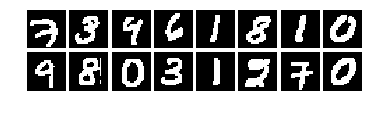

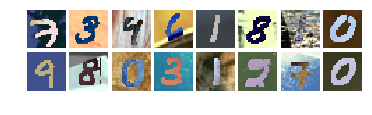

In [55]:
imshow_grid(mnist_train)
imshow_grid(mnistm_train)

In [56]:
mnist_train_labels = mnist.train.labels
mnist_test_labels = mnist.test.labels
mnist_valid_labels = mnist.validation.labels
print (len(mnist_train_labels), len(mnist_test_labels))
# print (mnist_train_labels[0:4])

(55000, 10000)


In [57]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10
input_shape = (img_rows, img_cols, 3)

In [75]:
x_train, y_train = mnist_train , mnist_train_labels
x_valid, y_valid = mnist_valid, mnist_valid_labels
Mx_train, My_train = mnistm_train , mnist_train_labels
Mx_valid, My_valid = mnistm_valid, mnist_valid_labels

In [76]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(5,5),activation='relu',input_shape=input_shape))
model.add(MaxPool2D())
model.add((Conv2D(48,kernel_size=(3, 3), activation='relu')))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(10,activation='relu'))
model.compile(loss='mse',optimizer='adam')
model = model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 48)        13872     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                12010     
Total para

In [77]:
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [78]:
SX=np.asarray(x_train)
SY=np.asarray(y_train)
SVX=np.asarray(x_valid)
SVY=np.asarray(y_valid)
input_shape=SX.shape[1:]

TX = np.asarray(Mx_train)
TY = np.asarray(My_train)
TVX = np.asarray(Mx_valid)
TVY = np.asarray(My_valid)

MX=np.concatenate((SX, TX), axis=0)
MY=np.concatenate((np.zeros(SX.shape[0]), np.ones(TX.shape[0])),axis=0)

MVX = np.concatenate((SVX, TVX),axis=0)
MVY = np.concatenate((np.zeros(SVX.shape[0]), np.ones(TVX.shape[0])),axis=0)

input_shape=SX.shape[1:]

In [79]:
def Train_classifier(x,y):
    x_features=model.predict(x)
    clf=RandomForestClassifier(n_estimators=18)
    clf=clf.fit(x_features, y)
    return clf

def Predict_from_clf(clf,x):
    x_features=model.predict(x)
    y=clf.predict(x_features)
    return y

def saveModel(filename):
    file=open(filename+'.json','w')
    file.write(model.to_json())
    model.save_weights(filename+'.h5')
    file.close()

def load_model(filename):
    file=open(filename+'.json')
    model=file.read()
    model=model_from_json(model)
    model.load_weight(filename+'.json')

def new_score_fun(label_accuracy,domain_accuray):
    return label_accuracy - (4*(np.square(domain_accuray-0.5)))

In [80]:
label_clf = RandomForestClassifier()
domain_clf = RandomForestClassifier()

In [81]:
RD_Indices = np.random.choice(a=list(range(MX.shape[0])),size=1024)
M_D_TX = MX[RD_Indices]
M_D_TY = MY[RD_Indices]

RS_Indices = np.random.choice(a=list(range(SX.shape[0])),size=1024)
S_TX = SX[RS_Indices]
S_TY = SY[RS_Indices]

RDV_indices = np.random.choice(a=list(range(MVX.shape[0])), size=1024)
M_D_VX = MVX[RDV_indices]
M_D_VY = MVY[RDV_indices]

SV_indices = np.random.choice(a=list((range(SVX.shape[0]))),size=1024)
validX = SVX[SV_indices]
validY = SVY[SV_indices]

In [82]:
label_clf = Train_classifier(SX,SY)
label_pred = Predict_from_clf(label_clf, validX)
label_accuracy = accuracy_score(validY,label_pred)
print ('label_accuracy',label_accuracy )

domain_clf = Train_classifier(M_D_TX, M_D_TY)
domain_pred = Predict_from_clf(domain_clf, M_D_VX)
domain_accuracy = accuracy_score(M_D_VY, domain_pred)
print ('domain_accuracy',domain_accuracy )

weight_modifier=NNWeightHelper(model)
weights=weight_modifier.get_weights()

print 'weights to evolve:',len(weights) 

('label_accuracy', 0.380859375)
('domain_accuracy', 0.9033203125)
weights to evolve: 28314


In [83]:
snes=SNES(weights,1,20)

In [84]:
logscore = []
for i in range(60):
    start = timer()
    new_weights=snes.ask()

    complied_score = []
    domain_accuracys = []
    label_accuracys = []

    for w in new_weights:
        RD_Indices = np.random.choice(a=list(range(MX.shape[0])),size=1024)
        M_D_TX = MX[RD_Indices]
        M_D_TY = MY[RD_Indices]

        RS_Indices = np.random.choice(a=list(range(SX.shape[0])),size=1024)
        S_TX = SX[RS_Indices]
        S_TY = SY[RS_Indices]

        RDV_indices = np.random.choice(a=list(range(MVX.shape[0])), size=1024)
        M_D_VX = MVX[RDV_indices]
        M_D_VY = MVY[RDV_indices]

        SV_indices = np.random.choice(a=list((range(SVX.shape[0]))),size=1024)
        validX = SVX[SV_indices]
        validY = SVY[SV_indices]
        weight_modifier.set_weights(w)

        label_clf=Train_classifier(S_TX,S_TY)
        label_predictions = Predict_from_clf(label_clf, validX)
        label_accuracy=accuracy_score(validY,label_predictions)
#         print ('label_accuracy',label_accuracy )

        domain_clf = Train_classifier(M_D_TX,M_D_TY)
        domain_predictions=Predict_from_clf(domain_clf,M_D_VX)
        domain_accuracy=accuracy_score(M_D_VY,domain_predictions)
#         print ('domain_accuracy',domain_accuracy )


        new_score = new_score_fun(label_accuracy, domain_accuracy)
        complied_score.append(new_score)
        domain_accuracys.append(domain_accuracy)
        label_accuracys.append(label_accuracy)

    snes.tell(new_weights,complied_score)
    max_index=np.argmax(complied_score)
    end = timer()
    print("It took", end - start, "seconds to complete generation")
    print("the fit model has label_accuracy: %0.3f and domain_accuracy:%0.3f and complied_score:%0.3f" 
          %(label_accuracys[max_index], domain_accuracys[max_index], complied_score[max_index]))
    
    logscore.append([complied_score[max_index],label_accuracys[max_index],domain_accuracys[max_index]])


('Step', 1, ':', -0.07291030883789062, 'best:', -0.07291030883789062, 20)
('It took', 20.770617961883545, 'seconds to complete generation')
the fit model has label_accuracy: 0.203 and domain_accuracy:0.763 and fitness_score:-0.073
('Step', 2, ':', 0.0, 'best:', 0.0, 20)
('It took', 20.403969049453735, 'seconds to complete generation')
the fit model has label_accuracy: 0.165 and domain_accuracy:0.703 and fitness_score:0.000
('Step', 3, ':', -0.027744293212890625, 'best:', 0.0, 20)
('It took', 20.43546199798584, 'seconds to complete generation')
the fit model has label_accuracy: 0.187 and domain_accuracy:0.731 and fitness_score:-0.028
('Step', 4, ':', -0.052677154541015625, 'best:', 0.0, 20)
('It took', 20.26436710357666, 'seconds to complete generation')
the fit model has label_accuracy: 0.279 and domain_accuracy:0.788 and fitness_score:-0.053
('Step', 5, ':', 0.00726318359375, 'best:', 0.00726318359375, 20)
('It took', 20.314198970794678, 'seconds to complete generation')
the fit model

('Step', 38, ':', 0.16845321655273438, 'best:', 0.17809677124023438, 20)
('It took', 20.213808059692383, 'seconds to complete generation')
the fit model has label_accuracy: 0.185 and domain_accuracy:0.563 and fitness_score:0.168
('Step', 39, ':', 0.16650009155273438, 'best:', 0.17809677124023438, 20)
('It took', 20.45617389678955, 'seconds to complete generation')
the fit model has label_accuracy: 0.182 and domain_accuracy:0.562 and fitness_score:0.167
('Step', 40, ':', 0.21883773803710938, 'best:', 0.21883773803710938, 20)
('It took', 20.444185972213745, 'seconds to complete generation')
the fit model has label_accuracy: 0.245 and domain_accuracy:0.581 and fitness_score:0.219
('Step', 41, ':', 0.22048568725585938, 'best:', 0.22048568725585938, 20)
('It took', 20.34163188934326, 'seconds to complete generation')
the fit model has label_accuracy: 0.228 and domain_accuracy:0.542 and fitness_score:0.220
('Step', 42, ':', 0.2383880615234375, 'best:', 0.2383880615234375, 20)
('It took', 20.

In [85]:
saveModel('mnistmodeltest_dense128_new')
import pandas as pd
scorelog = pd.DataFrame(logscore)
scorelog.to_csv('logscore1.csv', header=None)

In [86]:
weight_modifier.set_weights(snes.center)

In [87]:
label_clf = Train_classifier(mnist_train,mnist_train_labels)
sourcePredictions = Predict_from_clf(label_clf, mnist_test)
sourceAccuray = accuracy_score(mnist_test_labels,sourcePredictions)
print  "label predicitions on MNIST %0.3f" % (sourceAccuray)

targetPredictions = Predict_from_clf(label_clf, mnistm_test)
targetAccuracy = accuracy_score(targetPredictions, mnist_test_labels)
print "label predicitons on MNISTM %0.3f" %(targetAccuracy)

label predicitions on MNIST 0.268
label predicitons on MNISTM 0.103


In [88]:
R_MT_INDEX = np.random.choice(a=list(range(MX.shape[0])), size=MY.shape[0])
TM_X = MX[R_MT_INDEX]
TM_Y = MY[R_MT_INDEX]

TEST_MX = np.concatenate([mnist_test, mnistm_test], axis=0)
TEST_MY = np.concatenate([np.zeros(mnist_test.shape[0]), np.ones(mnistm_test.shape[0])], axis=0)

In [89]:
domain_clf = Train_classifier(TM_X, TM_Y)
domain_pred = Predict_from_clf(domain_clf, TEST_MX)
domain_accuracy= accuracy_score(TEST_MY, domain_pred)
print("domain predicitions accuracy: %0.3f" %(domain_accuracy))

domain predicitions accuracy: 0.555


In [92]:
log = pd.read_csv('logscore1.csv', header=None)
# print log

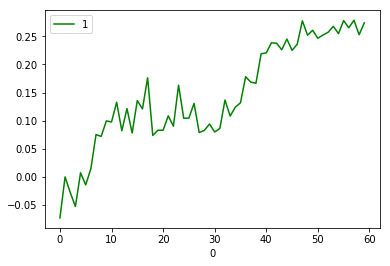

In [97]:
# log.plot()
log.plot(x=0, y=1, style='g')


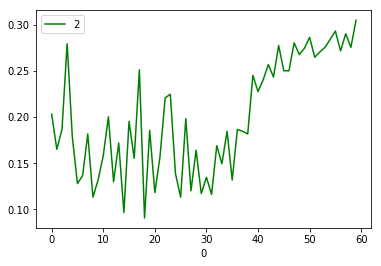

In [98]:
log.plot(x=0, y=2, style='g')

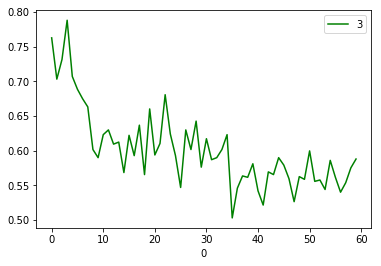

In [99]:
log.plot(x=0, y=3, style='g')